# SBA National Loan Analysis

# Modeling - Part 2 - Random Forest

## Table of Contents

1. Imports
2. Previewing Data
3. Preprocessing Data
    1. Standard Scaler
    2. Robust Scaler
4. Evaluation Metrics
5. Simple Model
    1. Standard Scaler
    2. Robust Scaler
6. Grid Search
    1. Standard Scaler
    2. Robust Scaler
7. Bayesian Optimization
    1. Standard Scaler
    2. Robust Scaler
8. Save Results
    
    

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestClassifier

from library.preprocessing import processing_pipeline
from library.modeling import (createModel, createClassificationMetrics, 
                             runGridSearchAnalysis, createConfusionMatrix, createFeatureImportanceChart,
                             appendModelingResults, drawRocCurve, obtain_best_bayes_model)

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [3]:
f = open('./results/best_params.json')
data = json.load(f)
best_model_params = dict(data)

model_results_df = pd.read_csv('./results/model_results.csv')
new_model_results = []

## 2. Previewing Data

In [4]:
sba_loans = pd.read_csv('./../data/processed/sba_national_processed_final.csv')

In [5]:
sba_loans.head()

,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,NAICS_sectors,unemployment_rate,gdp_growth,gdp_annual_change,inflation_rate,inf_rate_annual_chg,NewExist_existing_business,NewExist_new_business,UrbanRural_rural,UrbanRural_urban,isFranchise_not_franchise,RevLineCr_v2_N,RevLineCr_v2_Y,LowDoc_v2_N,LowDoc_v2_Y,MIS_Status_v2_default,state_top10
0,84,4,0,0,60000.0,60000.0,48000.0,45,3.5,4.4472,0.67,2.3377,-0.59,0,1,0,0,1,1,0,0,1,0,0
1,60,2,0,0,40000.0,40000.0,32000.0,72,3.5,4.4472,0.67,2.3377,-0.59,0,1,0,0,1,1,0,0,1,0,0
2,180,7,0,0,287000.0,287000.0,215250.0,62,3.5,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,1,0,0,0
3,60,2,0,0,35000.0,35000.0,28000.0,0,4.1,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,0,1,0,0
4,240,14,7,7,229000.0,229000.0,229000.0,0,4.8,4.4472,0.67,2.3377,-0.59,1,0,0,0,1,1,0,1,0,0,1


## 3. Preprocessing Data

In [6]:
target = 'MIS_Status_v2_default'
features = sba_loans.drop(columns='MIS_Status_v2_default', axis=1).columns

### A. Standard Scaler

In [7]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss = processing_pipeline(sba_loans, target)

### B. Robust Scaler

In [8]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = processing_pipeline(sba_loans, target, scaler='Robust')

## 4. Evaluation Metrics

The following evlaution metrics will be used to evaluate the effectiveness of the logistic models.

**Accuracy Score**

Blurb about accuracy score.

**Classifiation Report**

Blurb about Classification Report

**Matthew's Correlation Coefficient**

Blurb about MCC

**F1 Score**

Blurb about F1 Score and why it will be the main metric for evaluation

## 5. Simple Model

### A. Standard Scaler

In [9]:
rfc_ss_mod1 = RandomForestClassifier(random_state=42)
y_pred = createModel(rfc_ss_mod1, X_train_ss, y_train_ss, X_test_ss)

In [10]:
metrics = createClassificationMetrics(y_pred, y_test_ss)

In [11]:
print('Accuracy Score: ' + str(round(metrics['acc'], 4)))

Accuracy Score: 0.9384


In [12]:
print('Classification Report: \n' + metrics['cr'])

Classification Report: 
              precision    recall  f1-score   support

        paid       0.98      0.95      0.96    227409
     default       0.76      0.87      0.81     41445

    accuracy                           0.94    268854
   macro avg       0.87      0.91      0.89    268854
weighted avg       0.94      0.94      0.94    268854



In [13]:
print('Matthew\'s Correlation Coefficient: ' + str(round(metrics['mcc'],4)))

Matthew's Correlation Coefficient: 0.7783


In [14]:
print('F1 Score: ' + str(round(metrics['f1'], 4)))

F1 Score: 0.8127


### B. Robust Scaler

In [15]:
rfc_rs_mod1 = RandomForestClassifier(random_state=42)
y_pred = createModel(rfc_rs_mod1, X_train_rs, y_train_rs, X_test_rs)

In [16]:
metrics = createClassificationMetrics(y_pred, y_test_rs)

In [17]:
print('Accuracy Score: ' + str(round(metrics['acc'], 4)))

Accuracy Score: 0.9385


In [18]:
print('Classification Report: \n' + metrics['cr'])

Classification Report: 
              precision    recall  f1-score   support

        paid       0.98      0.95      0.96    227390
     default       0.77      0.87      0.81     41464

    accuracy                           0.94    268854
   macro avg       0.87      0.91      0.89    268854
weighted avg       0.94      0.94      0.94    268854



In [19]:
print('Matthew\'s Correlation Coefficient: ' + str(round(metrics['mcc'],4)))

Matthew's Correlation Coefficient: 0.7785


In [20]:
print('F1 Score: ' + str(round(metrics['f1'], 4)))

F1 Score: 0.813


## 6. Grid Search Cross Validation

In [21]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, None],
    'max_features': ['auto', 'log2']
}

### A. Standard Scaler

In [22]:
mod_info = {
    'model': 'Random Forest',
    'method': 'Grid Search',
    'scaler': 'Standard'
}

In [23]:
rfc = RandomForestClassifier(random_state=42)
rfc_ss_best_params, y_pred = runGridSearchAnalysis(rfc, param_grid, X_train_ss, y_train_ss, X_test_ss)

**Evaluation Metrics**

In [24]:
metrics = createClassificationMetrics(y_pred, y_test_ss)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.9378584659331831
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.95      0.96    227398
     default       0.76      0.87      0.81     41456

    accuracy                           0.94    268854
   macro avg       0.87      0.91      0.89    268854
weighted avg       0.94      0.94      0.94    268854

Matthew's Correlation Coefficient: 0.7763052183674407
F1 Score: 0.8111328412032693


**Confusion Matrix**

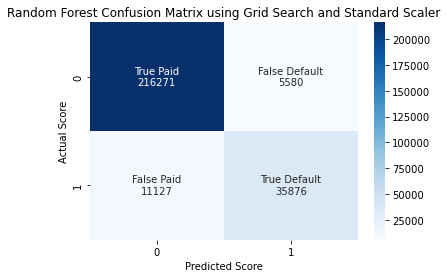

In [25]:
matrix = createConfusionMatrix(y_test_ss, y_pred, mod_info)

**ROC Curve**

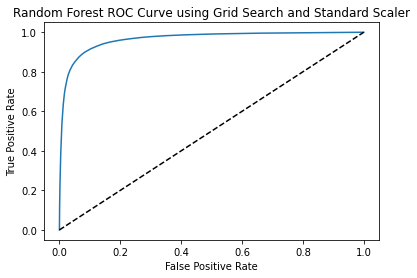

In [26]:
rfc_mod = RandomForestClassifier(**rfc_ss_best_params, random_state=42)
metrics['auc'] = drawRocCurve(rfc_mod, X_train_ss, X_test_ss, y_train_ss, y_test_ss, mod_info)

**Feature Importance with Best Params**

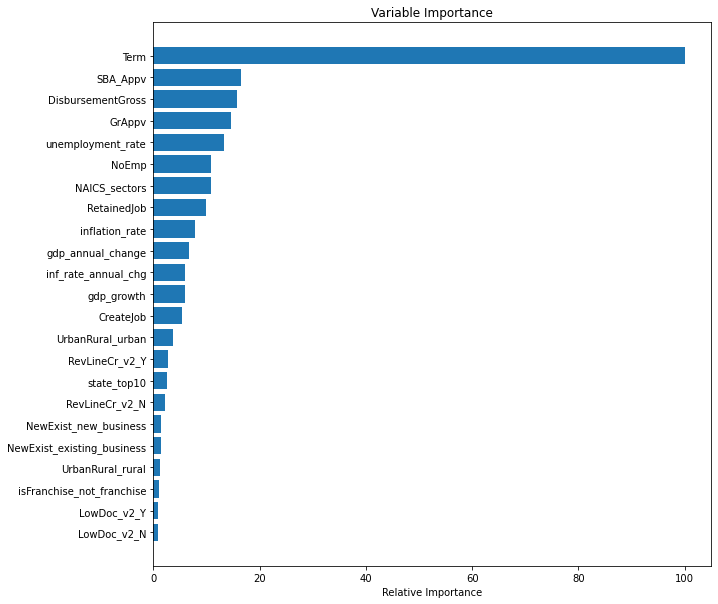

In [27]:
createFeatureImportanceChart(rfc_mod, features, X_train_ss, y_train_ss)

**Append Results**

In [28]:
new_model_results, best_model_params = appendModelingResults(new_model_results, best_model_params, mod_info,
                                                          rfc_ss_best_params, matrix, metrics)

### B. Robust Scaler

In [29]:
mod_info = {
    'model': 'Random Forest',
    'method': 'Grid Search',
    'scaler': 'Robust'
}

In [30]:
rfc = RandomForestClassifier(random_state=42)
rfc_rs_best_params, y_pred = runGridSearchAnalysis(rfc, param_grid, X_train_rs, y_train_rs, X_test_rs)

**Evaluation Metrics**

In [31]:
metrics = createClassificationMetrics(y_pred, y_test_rs)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.9379179777872005
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.95      0.96    227370
     default       0.76      0.87      0.81     41484

    accuracy                           0.94    268854
   macro avg       0.87      0.91      0.89    268854
weighted avg       0.94      0.94      0.94    268854

Matthew's Correlation Coefficient: 0.776554667224084
F1 Score: 0.8113734220846


**Confusion Matrix**

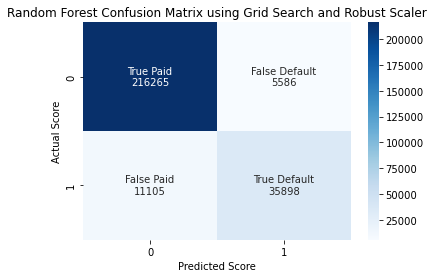

In [32]:
matrix = createConfusionMatrix(y_test_rs, y_pred, mod_info)

**ROC Curve**

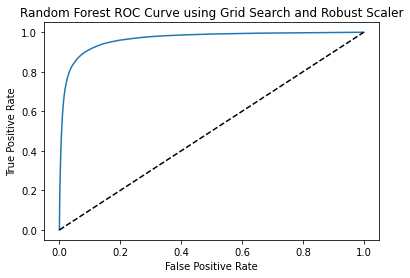

In [33]:
rfc_mod = RandomForestClassifier(**rfc_rs_best_params, random_state=42)
metrics['auc'] = drawRocCurve(rfc_mod, X_train_rs, X_test_rs, y_train_rs, y_test_rs, mod_info)

**Feature Importance with Best Params**

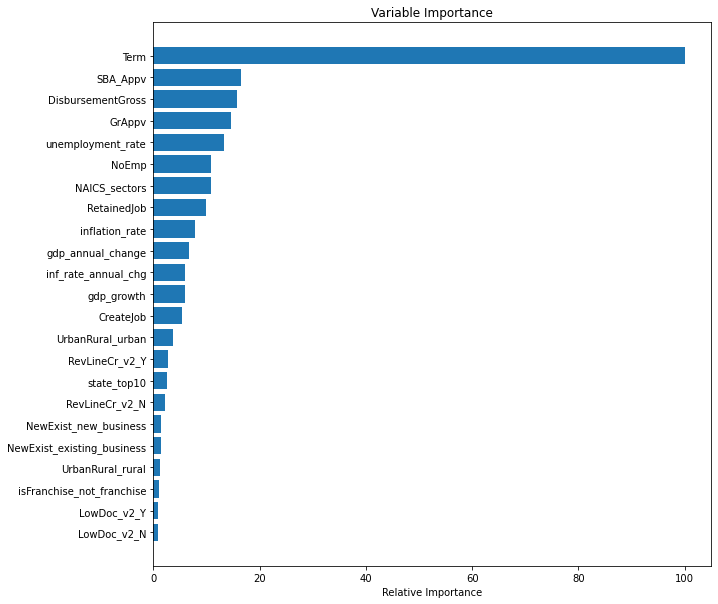

In [34]:
createFeatureImportanceChart(rfc_mod, features, X_train_rs, y_train_rs)

**Append Results**

In [35]:
new_model_results, best_model_params = appendModelingResults(new_model_results, best_model_params, mod_info,
                                                          rfc_rs_best_params, matrix, metrics)

## 7. Bayesian Optimization

In [36]:
dg = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, None],
    'max_features': ['auto', 'log2']
}
ss = {
    'criterion': (0,1),
    'max_depth': (0,1),
    'max_features': (0,1)
}

### A. Standard Scaler

In [37]:
mod_info = {
    'model': 'Random Forest',
    'method': 'Bayesian Optimization',
    'scaler': 'Standard'
}

In [38]:
rfc_bo_ss_params = obtain_best_bayes_model(RandomForestClassifier, X_train_ss, y_train_ss, dg, ss)

|   iter    |  target   | criterion | max_depth | max_fe... |
-------------------------------------------------------------
|  1        |  0.8074   |  0.3745   |  0.9507   |  0.732    |
|  2        |  0.803    |  0.5987   |  0.156    |  0.156    |
|  3        |  0.8074   |  0.05808  |  0.8662   |  0.6011   |
|  4        |  0.803    |  0.7081   |  0.02058  |  0.9699   |
|  5        |  0.803    |  0.8324   |  0.2123   |  0.1818   |
|  6        |  0.8074   |  0.005633 |  0.9857   |  0.9805   |
|  7        |  0.8074   |  0.0      |  1.0      |  0.0      |
|  8        |  0.8085   |  1.0      |  1.0      |  1.0      |
|  9        |  0.8085   |  1.0      |  1.0      |  0.4074   |
|  10       |  0.8085   |  1.0      |  1.0      |  0.0      |
|  11       |  0.8085   |  0.6285   |  1.0      |  0.0      |
|  12       |  0.8085   |  0.7411   |  1.0      |  0.2442   |
|  13       |  0.8085   |  1.0      |  1.0      |  0.7402   |
|  14       |  0.8085   |  0.8173   |  1.0      |  0.0      |
|  15   

In [39]:
rfc_bo_ss_mod1 = RandomForestClassifier(**rfc_bo_ss_params, random_state=42)
y_pred = createModel(rfc_bo_ss_mod1, X_train_ss, y_train_ss, X_test_ss)

**Evaluation Metrics**

In [40]:
metrics = createClassificationMetrics(y_pred, y_test_ss)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

Accuracy Score: 0.9378584659331831
Classification Report: 
              precision    recall  f1-score   support

        paid       0.97      0.95      0.96    227398
     default       0.76      0.87      0.81     41456

    accuracy                           0.94    268854
   macro avg       0.87      0.91      0.89    268854
weighted avg       0.94      0.94      0.94    268854

Matthew's Correlation Coefficient: 0.7763052183674407
F1 Score: 0.8111328412032693


**Confusion Matrix**

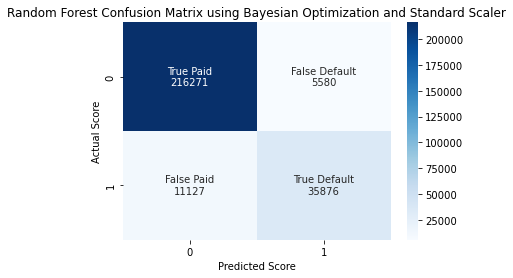

In [41]:
matrix = createConfusionMatrix(y_test_ss, y_pred, mod_info)

**ROC Curve**

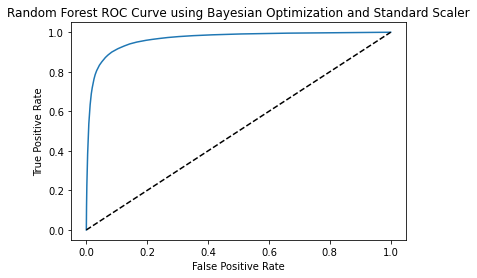

In [42]:
metrics['auc'] = drawRocCurve(rfc_bo_ss_mod1, X_train_ss, X_test_ss, y_train_ss, y_test_ss, mod_info)

**Feature Importance with Best Params**

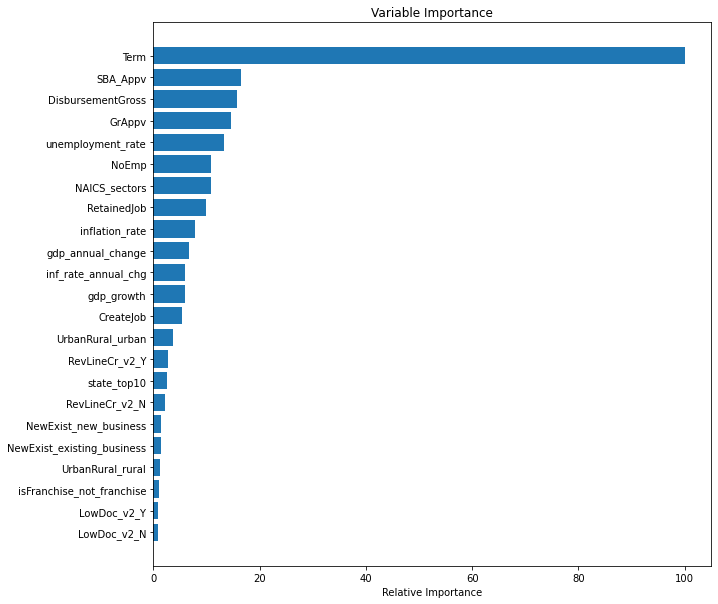

In [43]:
createFeatureImportanceChart(rfc_bo_ss_mod1, features, X_train_ss, y_train_ss)

**Append Results**

In [44]:
new_model_results, best_model_params = appendModelingResults(new_model_results, best_model_params, mod_info,
                                                          rfc_bo_ss_params, matrix, metrics)

### B. Robust Scaler

In [45]:
mod_info = {
    'model': 'Random Forest',
    'method': 'Bayesian Optimization',
    'scaler': 'Robust'
}

In [ ]:
rfc_bo_rs_params = obtain_best_bayes_model(RandomForestClassifier, X_train_rs, y_train_rs, dg, ss)

|   iter    |  target   | criterion | max_depth | max_fe... |
-------------------------------------------------------------
|  1        |  0.8077   |  0.3745   |  0.9507   |  0.732    |
|  2        |  0.8031   |  0.5987   |  0.156    |  0.156    |
|  3        |  0.8077   |  0.05808  |  0.8662   |  0.6011   |
|  4        |  0.8031   |  0.7081   |  0.02058  |  0.9699   |
|  5        |  0.8031   |  0.8324   |  0.2123   |  0.1818   |
|  6        |  0.8077   |  0.005633 |  0.9857   |  0.9805   |
|  7        |  0.8077   |  0.0      |  1.0      |  0.0      |
|  8        |  0.8086   |  1.0      |  1.0      |  1.0      |
|  9        |  0.8086   |  1.0      |  1.0      |  0.3529   |
|  10       |  0.8086   |  1.0      |  1.0      |  0.0      |


In [ ]:
rfc_bo_rs_mod1 = RandomForestClassifier(**rfc_bo_rs_params, random_state=42)
y_pred = createModel(rfc_bo_rs_mod1, X_train_rs, y_train_rs, X_test_rs)

**Evaulation Metrics**

In [ ]:
metrics = createClassificationMetrics(y_pred, y_test_ss)
print('Accuracy Score: {}'.format(metrics['acc']))
print('Classification Report: \n{}'.format(metrics['cr']))
print('Matthew\'s Correlation Coefficient: {}'.format(metrics['mcc']))
print('F1 Score: {}'.format(metrics['f1']))

**Confusion Matrix**

In [ ]:
matrix = createConfusionMatrix(y_test_rs, y_pred, mod_info)

**ROC Curve**

In [ ]:
metrics['auc'] = drawRocCurve(rfc_bo_rs_mod1, X_train_rs, X_test_rs, y_train_rs, y_test_rs, mod_info)

**Feature Importance with Best Params**

In [ ]:
createFeatureImportanceChart(rfc_bo_rs_mod1, features, X_train_rs, y_train_rs)

**Append Results**

In [ ]:
new_model_results, best_model_params = appendModelingResults(new_model_results, best_model_params, mod_info,
                                                          rfc_bo_rs_params, matrix, metrics)

## 5. Best Random Forest Model